## Случайный лес

### 1. Bias-Variance decomposition

Вспомним, что функцию потерь в задачах регрессии или классификации можно разложить на три компоненты: смещение (bias), дисперсию (variance) и шум (noise). Эти компоненты позволяют описать сложность алгоритма, альтернативно сравнению ошибок на тренировочной и тестовой выборках. Хотя такое разложение можно построить для произвольной функции потерь, наиболее просто (и классически) оно строится для среднеквадратичной функции в задаче регрессии, что мы и рассмотрим ниже. 

Пусть $(X, y)$ – некоторая выборка. Обучим интересующий нас алгоритм на этой выборке и сделаем предсказания на ней. Обозначим предсказания как $\hat{y}$. Тогда 

$$
\mathrm{bias} := \mathbb{E}(\hat{y}) - y.
$$

$$
\mathrm{variance} := \mathbb{E}[\mathbb{E}(\hat{y}) - \hat{y}]^2
$$

$$
\mathrm{noise} := \mathbb{E}[y - \mathbb{E}(y)]^2
$$

Ожидаемую среднеквадратичную ошибку для различных вариаций тренировочной выборки можно разложить как

$$
\mathrm{E}[y - \hat{y}]^2 = \mathrm{bias}^2 + \mathrm{variance} + \mathrm{noise}.
$$

Разберёмся с интерпретацией компонент. 

- $\mathrm{Bias}$ – показывает отклонение среднего ответа алгоритма от ответа идеального алгоритма. $\mathrm{Bias}$ отражает ошибку модели, возникающую из-за простоты модели. Высокое смещение обычно является показателем того, что модель недообучена.


- $\mathrm{Variance}$ – показывает разброс ответов алгоритмов относительно среднего ответа алгоритма. Показывает, насколько сильно небольшие изменения в обучающей выборке скажутся на предсказаниях алгоритма. $\mathrm{Variance}$ отражает ошибку модели, возникающую из-за чрезмерной сложности модели. Высокая дисперсия обычно является показателем того, что модель переобучена.


- $\mathrm{Noise}$ – ошибка идеального классификатора, естественный неустранимый шум в данных. 

Посмотрим наглядно на примере полиномиальной регрессии.

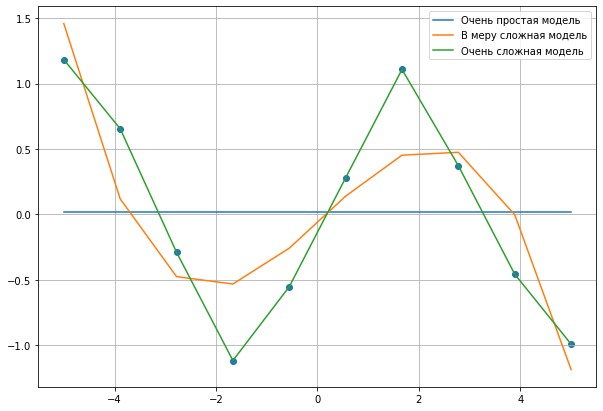

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Выборка
N = 10
X = np.linspace(-5, 5, N).reshape(-1, 1)
y = np.sin(X) + np.random.normal(0, 0.2, size = N).reshape(-1, 1)

# Очень простая модель (регрессия на константу)
too_simple_model_predictions = np.mean(y) * np.ones_like(y)

# В меру сложная модель
X_ok = np.hstack([X, X ** 2, X ** 3])
ok_model = LinearRegression()
ok_model.fit(X_ok, y)
ok_model_predictions = ok_model.predict(X_ok)

# Очень сложная модель
X_compl = np.hstack([X, X ** 2, X ** 3, X ** 4, X ** 5, X ** 6, X ** 7, X ** 8, X ** 9, X ** 10])
compl_model = LinearRegression()
compl_model.fit(X_compl, y)
compl_model_predictions = compl_model.predict(X_compl)

plt.figure(figsize = (10, 7))

plt.scatter(X, y)
plt.plot(X, too_simple_model_predictions, label = 'Очень простая модель')
plt.plot(X, ok_model_predictions, label = 'В меру сложная модель')
plt.plot(X, compl_model_predictions, label = 'Очень сложная модель')
plt.grid()
plt.legend();

- Очень простая модель имеет большое смещение (bias), но малую (нулевую) дисперсию (variance). Модель явно недообучена.

- В меру сложная модель имеет небольшое смещение (bias) и небольшую дисперсию (variance).

- Очень сложная модель имеет небольшое смещение (bias), но большую дисперсию (variance). Модель явно переобучена.

**Задание:** пользуясь определениями выше, объясните, почему это так.

**Задание:** прокомментируйте величину смещения и дисперсии для следующих моделей:

1. Линейная регрессия, обучаемая на большой выборке без выбросов и линейно зависимых признаков. (малые смещение и дисперсия)
2. Решающее дерево, которое строится до тех пор, пока в листах не окажется по одному объекту. (малое смещение, высокая дисперсия)
3. Логистическая регрессия, относящая все точки к одному классу. (большое смещение, малая дисперсия) 

### 1.A. Bias-Variance tradeoff

Из описания выше можно заметить, что при обучении моделей возникает выбор между смещением и дисперсией: недообученная модель имеет низкую дисперсию, но высокое смещение, а переобученная – низкое смещение, но высокую дисперсию. Этот выбор можно отобразить на картинке ([источник](https://www.bradyneal.com/bias-variance-tradeoff-textbooks-update)).

![](https://www.bradyneal.com/img/bias-variance/fortmann-roe-bias-variance.png)

Вывод из неё очевиден: строить следует оптимальные по сложности модели. 

Возникает ли такой выбор при обучении любой модели? Последние исследования показывают, что поведение ошибки при обучении некоторых (современных) моделей не соответствует такой U-образной форме. Например, было показано, что ошибка продолжает убывать при расширении (увеличении числа слоёв) нейронных сетей:

<img src="https://www.bradyneal.com/img/bias-variance/neyshabur.jpg" alt="drawing" width="400"/>

В таких моделях поведение ошибки приобретает сложный вид:


<img src="https://www.bradyneal.com/img/bias-variance/double_descent.jpg" alt="drawing" width="800"/>

### 3. От деревьев к случайному лесу

#### 3.1 Решающее дерево

Мотивацию построения алгоритма случайного леса (Random Forest) удобно рассматривать в терминах смещения и дисперсии. Начнём с построения решающего дерева.

In [ ]:
# !pip install mlxtend

In [ ]:
# Пример отсюда: http://rasbt.github.io/mlxtend/user_guide/evaluate/bias_variance_decomp/

from sklearn.model_selection import train_test_split
from mlxtend.data import boston_housing_data

X, y = boston_housing_data()
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 123,
                                                    shuffle = True)

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# TODO: обучите решающее дерево без ограничений на тренировочной выборке
# TODO: рассчитайте MSE на тренировочной и тестовой выборках

dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)

y_pred_train = dt.predict(X_train)
y_pred_test = dt.predict(X_test)

print('MSE train:', mean_squared_error(y_train, y_pred_train))
print('MSE test:', mean_squared_error(y_test, y_pred_test))

MSE train: 0.0
MSE test: 20.05921052631579


In [ ]:
?bias_variance_decomp

In [ ]:
# !pip install --upgrade mlxtend

In [ ]:
from mlxtend.evaluate import bias_variance_decomp

# TODO: воспользуйтесь функцией bias_variance_decomp и выведите среднее смещение и среднюю дисперсию модели
# на тестовой выборке

_, bias, variance = bias_variance_decomp(DecisionTreeRegressor(), X_train, y_train, X_test, y_test, loss = 'mse')

In [ ]:
bias

13.81222787664474

In [ ]:
variance

18.539756662828946

Как мы обсуждали на предыдущем семинаре, такое дерево окажется сильно переобученным (высокая дисперсия и низкое смещение). Постараемся исправить это. На лекции мы обсуждали, что один из способов борьбы с переобучением – построение композиций моделей. На этом семинаре мы рассмотрим построение композиций при помощи бэггинга.

#### 3.2 Бэггинг

Вспомним суть алгоритма:

1. Обучаем много деревьев на бутстрапированных подвыборках исходной выборки независимо друг от друга. Бутстрапированную подвыборку строим при помощи выбора $N$ (размер исходной выборки) наблюдений из исходной выборки с возвращением. 

2. Усредняем предсказания всех моделей (например, берём арифметическое среднее). 

Можно показать, что модель, построенная при помощи бэггинга, будет иметь **то же смещение**, что и у отдельных деревьев, но значительно **меньшую дисперсию** (при выполнении некоторых условий). 

In [ ]:
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor

base_tree = DecisionTreeRegressor(random_state = 123)

# TODO: обучите бэггинг с 20 деревьями, каждое из которых строится без ограничений
bagging = BaggingRegressor(base_tree, n_estimators=20)
bagging.fit(X_train, y_train)

# TODO: выведите среднее смещение и среднюю дисперсию модели на тестовой выборке
_, bias, variance = bias_variance_decomp(bagging, X_train, y_train, X_test, y_test, loss='mse')
bias, variance

(15.49388771229851, 4.102715558260691)

In [ ]:
avg_bias

15.698786665242594

In [ ]:
avg_var

3.82613624676398

Как мы видим, по сравнению с единичным деревом смещение практически не изменилось, но дисперсия уменьшилась в несколько раз!

Посмотрим, как это отразилось на среднеквадратичной ошибке.

In [ ]:
# TODO: рассчитайте MSE на тренировочной и тестовой выборках для бэггинга


Среднеквадратичная ошибка на тренировочной выборке больше не равна 0, а на тестовой – уменьшилась, что говорит о том, что мы успешно победили переобучение единичного решающего дерева. 

Можем ли мы снизить переобучение ещё сильнее? Можем!

#### 3.3 Случайный лес

При построении каждого дерева в бэггинге в ходе создания очередного узла будем выбирать случайный набор признаков, на основе которых производится разбиение. В результате такой процедуры мы уменьшим корреляцию между деревьями, за счёт чего снизим дисперсию итоговой модели. Такой алгоритм назвывается **случайным лесом** (Random Forest). 

По сравнению с единичным деревом к параметрам случайного леса добавляются:
- `max_features` – число признаков, на основе которых проводятся разбиения при построении дерева.

- `n_estimators` – число деревьев. 

Естественно, все параметры, относящиеся к единичному дереву, сохраняются для случайного леса.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# TODO: обучите случайный лес с 20 деревьями, каждое из которых строится без ограничений
rf = RandomForestRegressor(n_estimators=20)

# TODO: выведите среднее смещение и среднюю дисперсию модели на тестовой выборке
_, bias, variance = bias_variance_decomp(rf, X_train, y_train, X_test, y_test, loss = 'mse')
bias, variance

# TODO: рассчитайте MSE на тренировочной и тестовой выборках для случайного леса


(15.654277413363472, 4.229368943544408)

In [ ]:
avg_bias

15.645907080711353

In [ ]:
avg_var

3.8086950960978614

Как мы видим, по сравнению с бэггингом смещение вновь осталось практически неизменным, а дисперсия немного уменьшилась. Конечно, если подобрать хорошие гиперпараметры, то получится снизить дисперсию ещё больше. 

Ошибка на тренировочной выборке увеличилась, а на тестовой – уменьшилась, что означает, что мы добились нашей цели в борьбе с переобученными деревьями!

### 4. Особенности случайного леса

#### 4.1 Число деревьев и "Случайный лес не переобучается"

В своём [блоге](https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm#remarks) Лео Бриман (Leo Breiman), создатель случайного леса, написал следующее:

> Random forest does not overfit. You can run as many trees as you want.

**Обратите внимание:** как говорилось на лекции, случайный лес не переобучается именно с ростом числа деревьев (за счёт совместной работы бэггинга и использования случайных подпространств), но не в принципе. Посмотрим на поведение случайного леса при росте числа деревьев.

In [ ]:
X, y = boston_housing_data()
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 123,
                                                    shuffle = True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

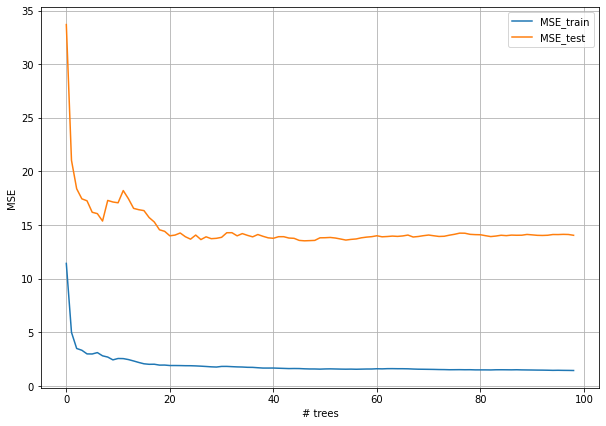

In [ ]:
n_trees = 100
train_loss = []
test_loss = []

for i in range(1, n_trees):
    rf = RandomForestRegressor(n_estimators = i, random_state = 123)
    rf.fit(X_train, y_train)
    train_loss.append(mean_squared_error(y_train, rf.predict(X_train)))
    test_loss.append(mean_squared_error(y_test, rf.predict(X_test)))
    
plt.figure(figsize = (10, 7))
plt.grid()
plt.plot(train_loss, label = 'MSE_train')
plt.plot(test_loss, label = 'MSE_test')
plt.ylabel('MSE')
plt.xlabel('# trees')
plt.legend();

Как и ожидалось, по достижении некоторого числа деревьев обе ошибки практически не изменяются, то есть переобучения при росте числа деревьев не происходит.

Однако в какой-нибудь другой плоскости на реальных данных переобучение может произойти: [пример 1](https://datascience.stackexchange.com/questions/1028/do-random-forest-overfit), [пример 2](https://mljar.com/blog/random-forest-overfitting/). 

В нашем же случае случайный лес, скорее, лишь страдает от регуляризации. Например, посмотрим на поведение модели при изменении максимальной глубины деревьев (поэксперементируйте с другими параметрами).

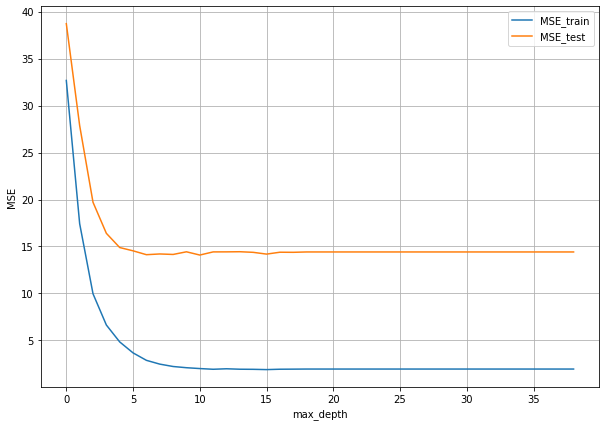

In [ ]:
max_depth = 40
train_loss = []
test_loss = []

for i in range(1, max_depth):
    rf = RandomForestRegressor(n_estimators = 20, max_depth = i, random_state = 123)
    rf.fit(X_train, y_train)
    train_loss.append(mean_squared_error(y_train, rf.predict(X_train)))
    test_loss.append(mean_squared_error(y_test, rf.predict(X_test)))
    
plt.figure(figsize = (10, 7))
plt.grid()
plt.plot(train_loss, label = 'MSE_train')
plt.plot(test_loss, label = 'MSE_test')
plt.ylabel('MSE')
plt.xlabel('max_depth')
plt.legend();

Переобучение не наблюдается. Вообще же, как обычно, гиперпараметры случайного леса стоит подбирать на кросс-валидации.

#### 4.2 Out-of-bag-ошибка

Как мы обсудили выше, при построении случайного леса каждое дерево строится на бутстрапированной подвыборке, полученной из исходной обучающей выборки случайным набором с повторениями. Понятно, что некоторые наблюдения попадут в такую подвыборку несколько раз, а некоторые не войдут в неё вообще. Для каждого дерева можем рассмотреть объекты, которые не участвовали в обучении и использовать их для валидации.

Усреднённая ошибка на неотобранных образцах по всему случайному лесу называется **out-of-bag-ошибкой**.

In [ ]:
X, y = boston_housing_data()
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 123,
                                                    shuffle = True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

# oob_score_ = R2 на невиденных наблюдениях
rf = RandomForestRegressor(n_estimators = 100, random_state = 123, oob_score = True, n_jobs=-1)
rf.fit(X_train, y_train)
rf.oob_score_

0.8761263356544452

In [ ]:
pred = rf.predict(X_test)

from sklearn.metrics import r2_score

r2_score(y_test, pred)

0.8249866263834764

#### 4.3 Важность признаков

Как и решающие деревья, случайный лес позволяет оценивать важность признаков.

In [ ]:
from sklearn.datasets import load_boston
data = load_boston()

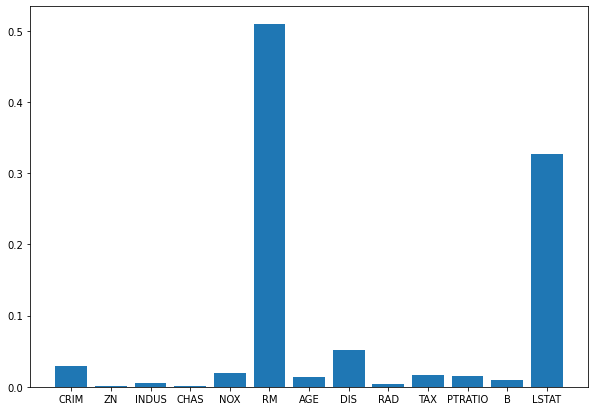

In [ ]:
plt.figure(figsize = (10, 7))
plt.bar(data['feature_names'], rf.feature_importances_);

Будьте осторожны с сильно коррелирующими признаками. Посмотрим, что произойдёт с важностью, если добавить в выборку линейно зависимый признак.

In [ ]:
RM_mc = (X_train[:, 5] * 2 + 3).reshape(-1, 1)
X_train_new = np.hstack((X_train, RM_mc))

In [ ]:
rf.fit(X_train_new, y_train)

RandomForestRegressor(oob_score=True, random_state=123)

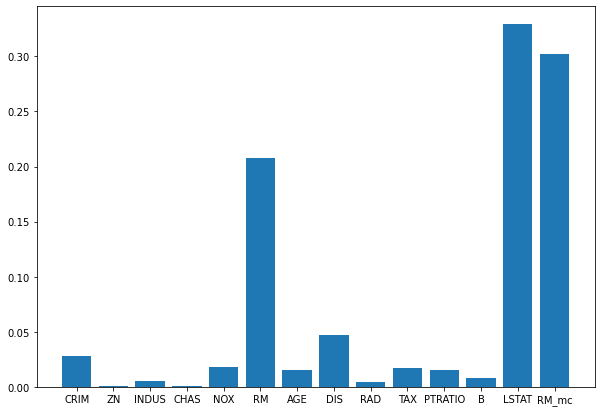

In [ ]:
plt.figure(figsize = (10, 7))
names = list(data['feature_names'])
names.append('RM_mc')
plt.bar(names, rf.feature_importances_);

Важности перераспределились между линейной зависимыми признаками `RM` и `RM_mc`. Не забывайте учитывать корреляции между признаками, если вы используете этот метод для отбора признаков. Также обратите внимание на предупреждение в документации `sklearn`: не стоит использовать этот метод и для признаков, в которых есть много уникальных значений (например, категориальные признаки с небольшим числом категорий). 

### 5. Тестирование случайного леса на разных данных

Ниже представлены шаблоны для сравнения случайного леса и других моделей на данных разных типов. Проведите побольше экспериментов, используя разные модели и метрики. Попробуйте подобрать гиперпараметры случайного леса так, чтобы достичь какого-нибудь порога качества. 

**Внимание:** в этой части вам предстоит скачивать объёмные наборы данных. Не забудьте удалить их после семинара, если не планируете использовать их в дальнейшем, чтобы они не занимали лишнее место на вашем компьютере.

**! Случайный лес может обучаться достаточно долго.**

#### 5.1 Бинарная классификация на примере [Kaggle Predicting a Biological Response](https://www.kaggle.com/c/bioresponse/data?select=train.csv)

In [ ]:
# Загрузка данных
!wget  -O 'kaggle_response.csv' -q 'https://www.dropbox.com/s/uha70sej5ugcrur/_train_sem09.csv?dl=1'

In [ ]:
data = pd.read_csv('kaggle_response.csv')
X = data.iloc[:, 1:].values
y = data.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# TODO: обучите логистическую регрессию и случайный лес с дефолтными параметрами
# Сравните их AUC ROC на тестовой выборке


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
roc_auc_score(y_test, pred_rf[:, 1])

0.8767595559624628

In [ ]:
roc_auc_score(y_test, pred_lr[:, 1])

0.8015754940108338

#### 5.2 Изображения на примере [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist)

In [ ]:
# Загрузка данных
import torchvision

fmnist = torchvision.datasets.FashionMNIST('./', download = True)
X = fmnist.data.numpy().reshape(-1, 28 * 28)
y = fmnist.targets.numpy()

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



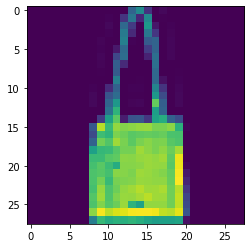

In [ ]:
plt.imshow(X[200, :].reshape(28, 28))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

# TODO: обучите случайный лес и kNN с дефолтными параметрами
# Сравните их доли правильных ответов на тестовой выборке

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
pred_knn = knn.predict(X_test)

In [ ]:
accuracy_score(y_test, pred_rf)

0.8805

In [ ]:
accuracy_score(y_test, pred_knn)

0.8505555555555555